<a href="https://colab.research.google.com/github/serendu10/Retail-Customer-Segmentation/blob/main/Finance_Freud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import io
from tensorflow import keras

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:
# Import data
Transaction = pq.read_table('/content/drive/My Drive/Colab Notebooks/credit_card_transaction_data_de.parquet copy').to_pandas()
User = pq.read_table('/content/drive/My Drive/Colab Notebooks/credit_card_users_de.parquet copy').to_pandas().reset_index()
Card = pq.read_table('/content/drive/My Drive/Colab Notebooks/sd254_cards_de.parquet copy').to_pandas()

In [33]:
# Join Transaction with User
df = pd.merge(Transaction,User,left_on='User',right_on='index',how='left')
# Join the anove with Card
df = pd.merge(df,Card,left_on=['Card','User'],right_on=['CARD INDEX','User'],how='left')

**Data Cleaning**

In [34]:
# Create new columns
df.loc[(df['Current Age']>=df['Retirement Age']),'Retired'] = 'Y'
df.loc[(df['Current Age']<df['Retirement Age']),'Retired'] = 'N'
df["Hour"] = df["Time"].str[:2]
df["Min"] = df["Time"].str[-2:]
df = df.drop(['Time'],axis=1)
df['Expires Month'] = df['Expires'].str[:2]
df['Expires Year'] = df['Expires'].str[-4:]
df = df.drop(['Expires'],axis=1)
df['Open Month'] = df['Acct Open Date'].str[:2]
df['Open Year'] = df['Acct Open Date'].str[-4:]
df = df.drop(['Acct Open Date'],axis=1)
# Drop unnecessary column
df = df[['Year', 'Month', 'Day','Hour','Min','Amount', 'Use Chip',
        'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?','Current Age','Retired','Birth Year', 'Birth Month','Gender','City', 'State',
       'Zipcode','Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score','Num Credit Cards','Card Brand',
       'Card Type', 'Card Number', 'Expires Month', 'Expires Year','CVV', 'Has Chip',
       'Cards Issued', 'Credit Limit', 'Open Month','Open Year',
       'Year PIN last Changed', 'Card on Dark Web']]

In [35]:
# Change data types
df['Amount']=df['Amount'].str.replace('$', '').astype(float)
df['Per Capita Income - Zipcode']=df['Per Capita Income - Zipcode'].str.replace('$', '').astype(float)
df['Yearly Income - Person']=df['Yearly Income - Person'].str.replace('$', '').astype(float)
df['Total Debt']=df['Total Debt'].str.replace('$', '').astype(float)
df['Credit Limit']=df['Credit Limit'].str.replace('$', '').astype(float)

df['Hour'] = df['Hour'].astype(int)
df['Min'] = df['Min'].astype(int)
df['Expires Month'] = df['Expires Month'].astype(int)
df['Expires Year'] = df['Expires Year'].astype(int)
df['Open Month'] = df['Open Month'].astype(int)
df['Open Year']  = df['Open Year'] .astype(int)

**EDA**

In [ ]:
data = df[df['Is Fraud?'] == 'Yes']

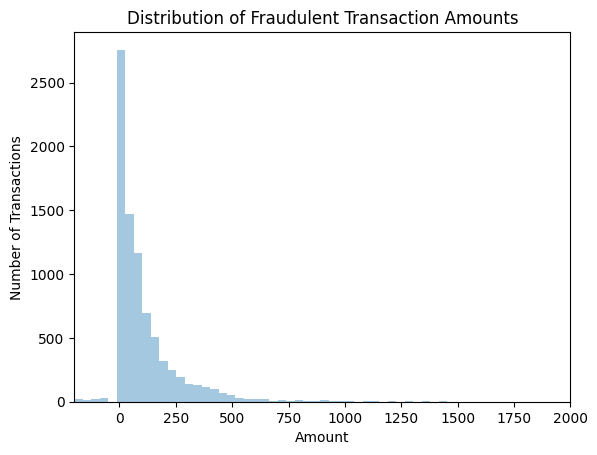

In [ ]:
# Plot Fraud Amount
sns.distplot(data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

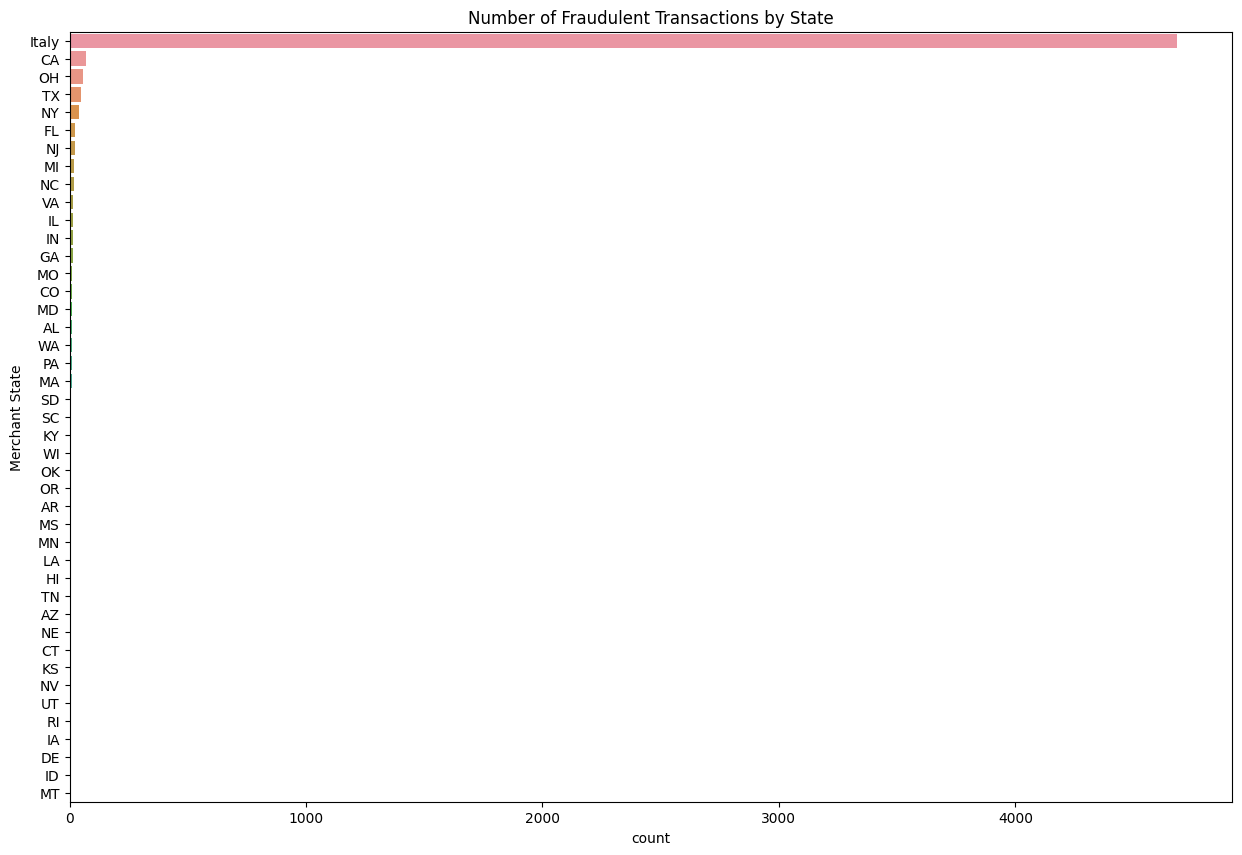

In [ ]:
# Plot Top 50 Fraud Locations
plt.figure(figsize=(15, 10))
sns.countplot(data=data, y='Merchant State', order=data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

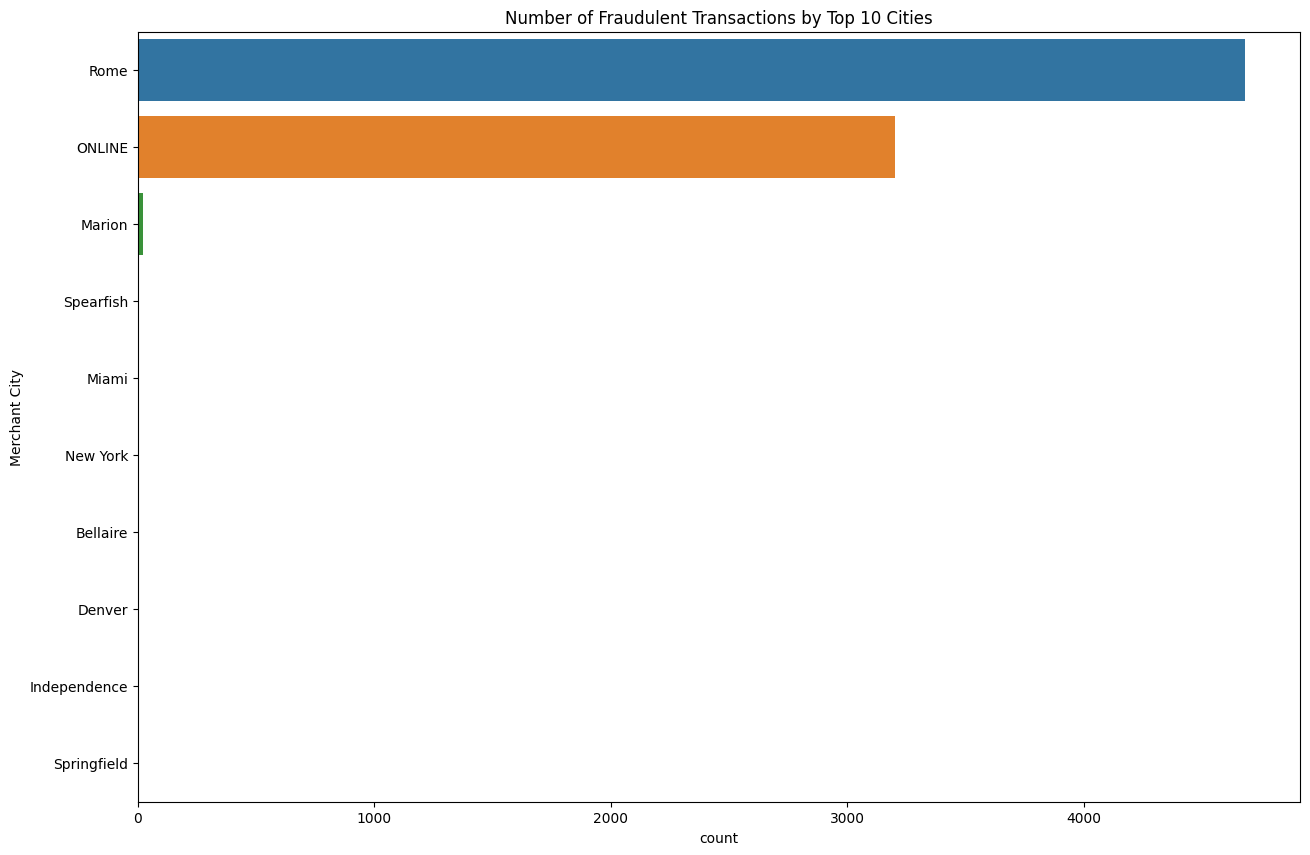

In [ ]:
# Plot Top 10 Fraud City
plt.figure(figsize=(15, 10))
top_cities = data['Merchant City'].value_counts().head(10).index
sns.countplot(data=data, y='Merchant City', order=top_cities)
plt.title('Number of Fraudulent Transactions by Top 10 Cities')
plt.show()

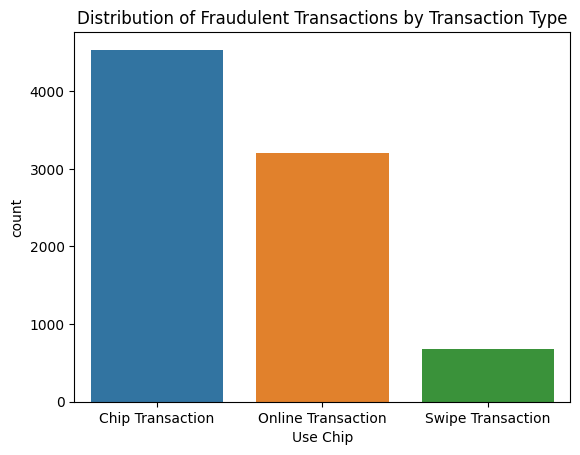

In [ ]:
# Plot Fraud Transaction Type
sns.countplot(data=data, x='Use Chip')
plt.title('Distribution of Fraudulent Transactions by Transaction Type')
plt.show()

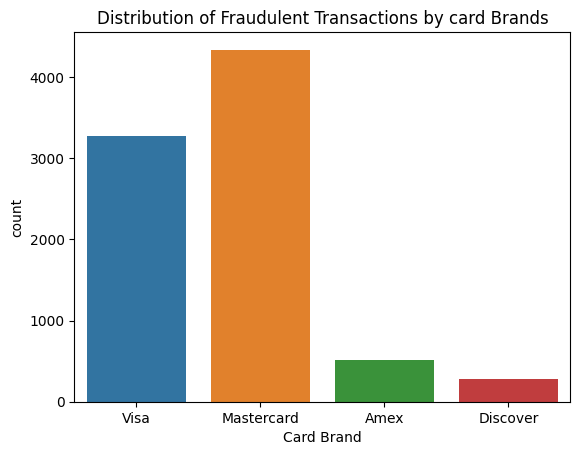

In [ ]:
# Plot Fraud by Card Brand
sns.countplot(data=data, x='Card Brand')
plt.title('Distribution of Fraudulent Transactions by card Brands')
plt.show()

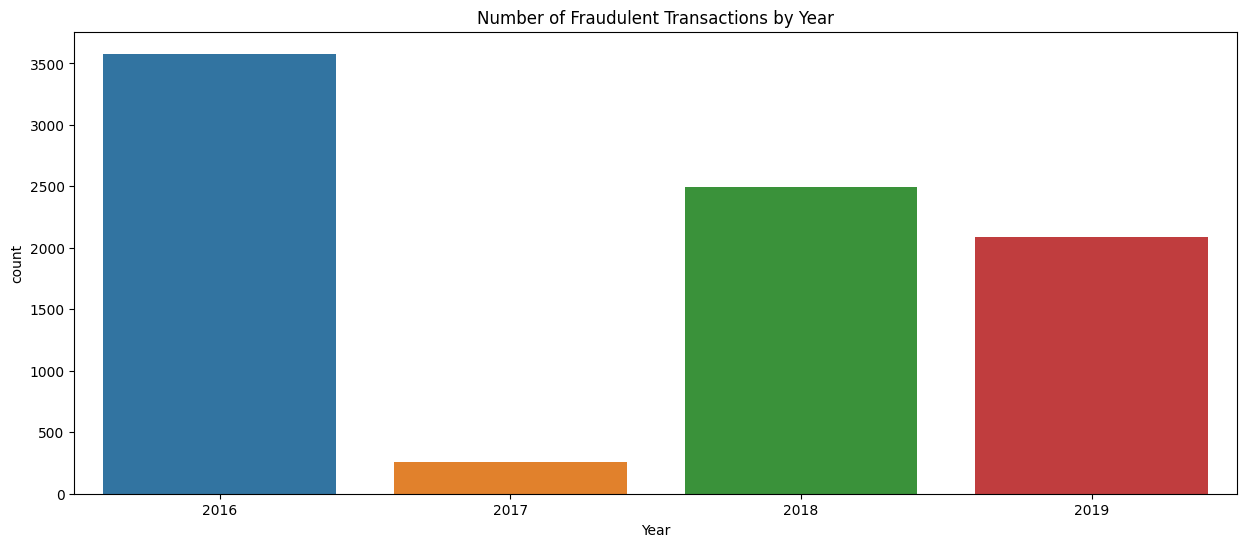

In [ ]:
# Plot Fraud by Year
plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()

**Data Pre-processing**

<function matplotlib.pyplot.show(close=None, block=None)>

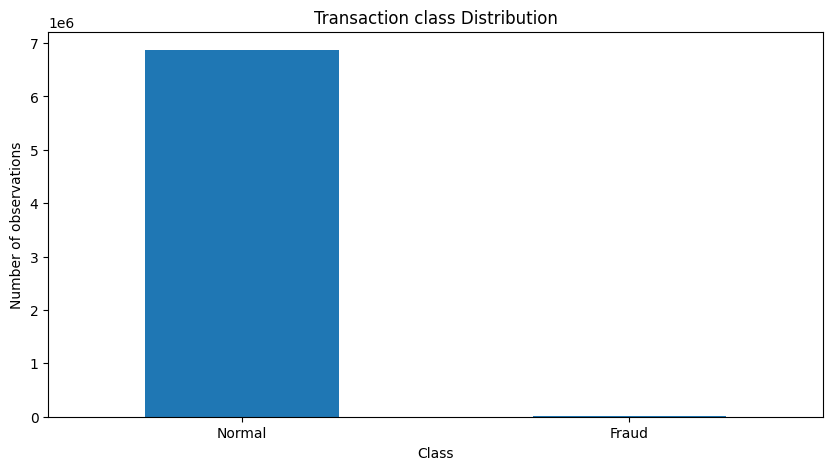

In [36]:
# Check if data is unbalanced -- very much skewed
classification = df['Is Fraud?'].value_counts(sort= True)
LABELS=('Normal','Fraud')
plt.figure(figsize=(10,5))
classification.plot(kind = 'bar',rot=0)
plt.xlabel('Class')
plt.ylabel('Number of observations')
plt.xticks(range(2), LABELS)
plt.title('Transaction class Distribution')
plt.show

In [37]:
# Correcting the Imbalance in Dataset using Undersampling method
# Separate majority and minority classes
Normal = df[df['Is Fraud?'] == 'No']
Freud = df[df['Is Fraud?'] == 'Yes']
# Downsample majority class
df_normal_downsampled = resample(Normal,
                                   replace=False,
                                   n_samples=len(Freud),
                                   random_state=42)
# Combine minority class with downsampled majority class
df = pd.concat([df_normal_downsampled, Freud])

In [38]:
# change the is fraud column to binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [39]:
# Divide Categorical and Numerical Variables
Num = ['Year', 'Month', 'Day', 'Hour', 'Min', 'Amount',
       'Zip','MCC', 'Current Age','Birth Year', 'Birth Month', 'Zipcode', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'Card Number','Expires Month', 'Expires Year', 'CVV','Cards Issued',
       'Credit Limit', 'Open Month', 'Open Year', 'Year PIN last Changed']
Cat = ['Use Chip','Merchant City', 'Merchant State','Errors?','Retired', 'Gender',
       'City', 'State','Card Brand', 'Card Type','Has Chip','Card on Dark Web']
y = ['Is Fraud?']

In [40]:
# Fillna
df[Num] = df[Num].fillna(0)

In [41]:
# Scaling
scaler = StandardScaler()
# Fit and transform the numerical data
scaled_df_Num = scaler.fit_transform(df[Num])
scaled_features_df_Num = pd.DataFrame(scaled_df_Num, index=df[Num].index, columns=df[Num].columns)
# Combine
df = pd.concat([scaled_features_df_Num,df[Cat],df[y]],axis=1)

In [42]:
# Dummy Coding
df = pd.get_dummies(df, columns = Cat,dtype=float)

**Feature Selection**

In [43]:
# Split the data into training and testing sets
X = df.loc[:, df.columns != 'Is Fraud?']
y = df['Is Fraud?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Feature Selection with Elastic Net
# Define a grid of hyperparameters to search
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
# Initialize Elastic Net model
elastic_net = ElasticNet()
# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Fit the grid search on the training data
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
# Get the best model
best_model = grid_search.best_estimator_
# Get selected features (non-zero coefficients)
coefficients = best_model.coef_
selected_features = X_train.columns[coefficients != 0]

In [45]:
selected_features

Index(['Year', 'Month', 'Day', 'Min', 'Amount', 'Zip', 'MCC', 'Birth Year',
       'Birth Month', 'Zipcode',
       ...
       'State_VA', 'State_VT', 'State_WI', 'Card Brand_Amex',
       'Card Brand_Discover', 'Card Brand_Mastercard', 'Card Type_Debit',
       'Card Type_Debit (Prepaid)', 'Has Chip_NO', 'Has Chip_YES'],
      dtype='object', length=373)

In [46]:
# Feature Selection
X_selected_train = X_train[selected_features]
X_selected_test = X_test[selected_features]

**Logistic Regression**

In [ ]:
# Initialize the Logistic Regression model
logistic_reg = LogisticRegression(max_iter=1000)
# Define a grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='accuracy')
# Fit the grid search on the training data
grid_search.fit(X_selected_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
# Get the best model
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'C': 100, 'penalty': 'l2'}


In [ ]:
# Evaluate the model on the test set
y_pred = best_model.predict(X_selected_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")
print("Logistic Regression Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Test Set: 0.95037147102526
Logistic Regression Results with Best Hyperparameters:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1684
           1       0.95      0.95      0.95      1681

    accuracy                           0.95      3365
   macro avg       0.95      0.95      0.95      3365
weighted avg       0.95      0.95      0.95      3365

[[1608   76]
 [  91 1590]]


**Random Forest**

In [ ]:
# Modeling with Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro')

grid_search.fit(X_selected_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_selected_test)
print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1684
           1       0.98      0.96      0.97      1681

    accuracy                           0.97      3365
   macro avg       0.97      0.97      0.97      3365
weighted avg       0.97      0.97      0.97      3365

[[1654   30]
 [  75 1606]]


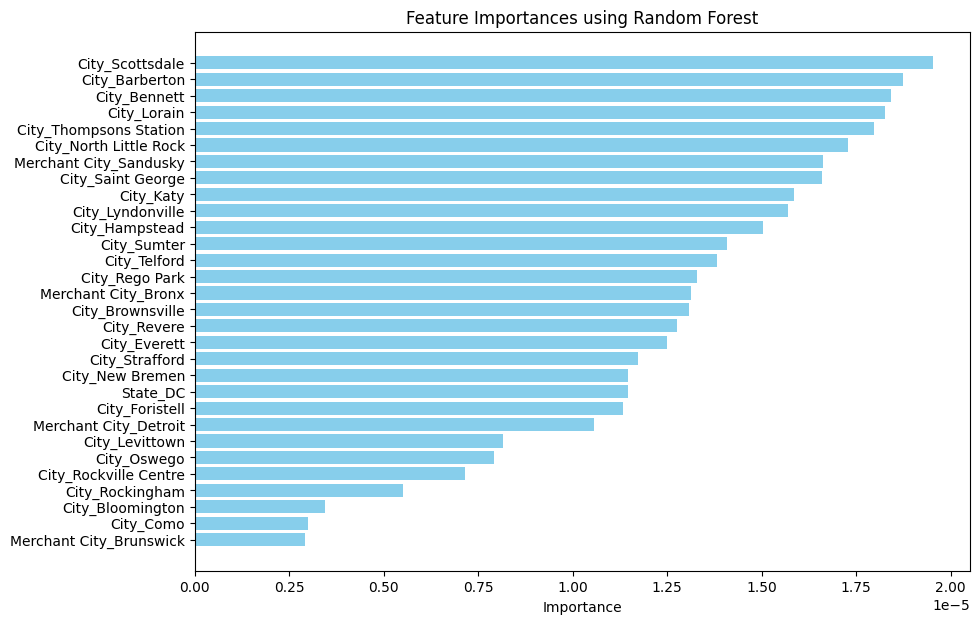

In [ ]:
# Extract feature importances from the best random forest model
feature_importance = best_rf.feature_importances_
features = X_selected_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx][:30], feature_importance[sorted_idx][:30], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

**XGBoost**

In [ ]:
# Model with XGBoost
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_selected_train, y_train)
best_params = grid_search.best_params_
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_selected_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Use the best estimator for predictions or further work
y_pred_best_rf = best_model.predict(X_selected_test)
print("XGBoost Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

XGBoost Results with Best Hyperparameters:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1684
           1       0.98      0.98      0.98      1681

    accuracy                           0.98      3365
   macro avg       0.98      0.98      0.98      3365
weighted avg       0.98      0.98      0.98      3365

[[1653   31]
 [  41 1640]]


**Artificial Neural Network**

In [55]:
# Define Layers
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu", input_shape=(X_selected_train.shape[-1],)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                11968     
                                                                 
 dense_5 (Dense)             (None, 128)               4224      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49473 (193.25 KB)
Trainable params: 4947

In [59]:
# Training
model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
                    X_selected_train,
                    y_train,
                    batch_size=2048,
                    epochs=30,
                    verbose=2,
                    validation_split = 0.2)

Epoch 1/30
6/6 - 3s - loss: 0.2303 - accuracy: 0.9185 - val_loss: 0.1492 - val_accuracy: 0.9406 - 3s/epoch - 552ms/step
Epoch 2/30
6/6 - 0s - loss: 0.1488 - accuracy: 0.9486 - val_loss: 0.1534 - val_accuracy: 0.9365 - 303ms/epoch - 51ms/step
Epoch 3/30
6/6 - 0s - loss: 0.1287 - accuracy: 0.9491 - val_loss: 0.1536 - val_accuracy: 0.9424 - 325ms/epoch - 54ms/step
Epoch 4/30
6/6 - 0s - loss: 0.1118 - accuracy: 0.9614 - val_loss: 0.1226 - val_accuracy: 0.9458 - 437ms/epoch - 73ms/step
Epoch 5/30
6/6 - 0s - loss: 0.0935 - accuracy: 0.9660 - val_loss: 0.1272 - val_accuracy: 0.9473 - 358ms/epoch - 60ms/step
Epoch 6/30
6/6 - 0s - loss: 0.0829 - accuracy: 0.9697 - val_loss: 0.1311 - val_accuracy: 0.9502 - 339ms/epoch - 56ms/step
Epoch 7/30
6/6 - 1s - loss: 0.0745 - accuracy: 0.9724 - val_loss: 0.1331 - val_accuracy: 0.9528 - 550ms/epoch - 92ms/step
Epoch 8/30
6/6 - 0s - loss: 0.0650 - accuracy: 0.9772 - val_loss: 0.1354 - val_accuracy: 0.9551 - 362ms/epoch - 60ms/step
Epoch 9/30
6/6 - 0s - loss

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(0, -0.05, '−0.05'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.10000000000000002, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25000000000000006, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35')])

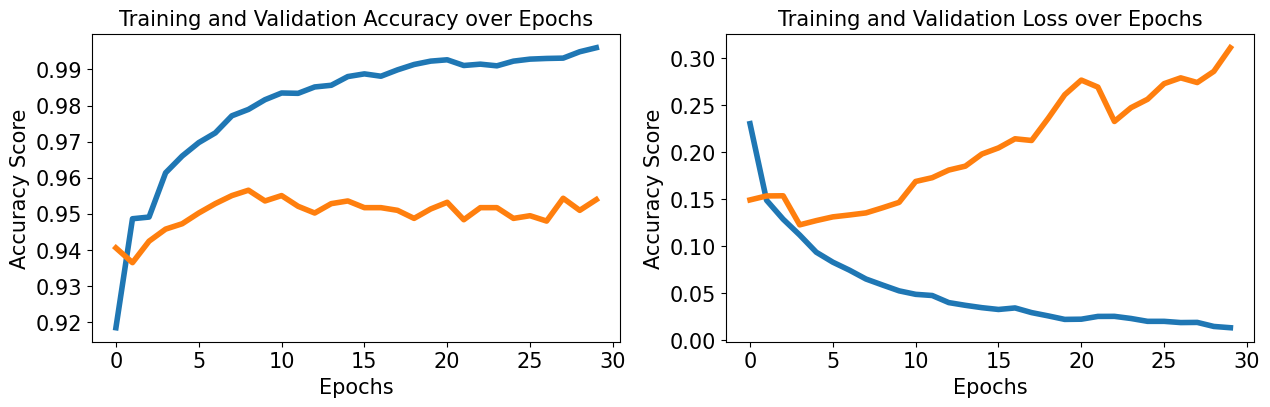

In [60]:
# Accuracy
results = pd.DataFrame(history.history)
plt.figure(figsize = (15,4))

plt.subplot(121)
plt.plot(results.index, results.accuracy, label="Training Accuracy", linewidth=4)
plt.plot(results.index, results.val_accuracy, label="Validation Accuracy", linewidth=4)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.title("Training and Validation Accuracy over Epochs" , fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(122)
plt.plot(results.index, results.loss, label="Training Loss", linewidth=4)
plt.plot(results.index, results.val_loss, label="Validation Loss", linewidth=4)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.title("Training and Validation Loss over Epochs", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [61]:
# Predicting the Test result
y_pred = model.predict(X_selected_test)
y_pred = (y_pred>0.5)
print("Accuracy Score : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))

106/106 [==============================] - 0s 2ms/step
Accuracy Score :  0.9435364041604755
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1684
           1       0.94      0.95      0.94      1681

    accuracy                           0.94      3365
   macro avg       0.94      0.94      0.94      3365
weighted avg       0.94      0.94      0.94      3365

Confusion Matrix:  [[1576  108]
 [  82 1599]]
